In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from glob import glob
from folium import plugins
from folium.plugins import HeatMap
from bokeh.plotting import figure
from bokeh.io import show, output_notebook
import folium
from branca.element import Template, MacroElement

In [19]:
# fichier des données, adresse à adapter
dfOriginel = pd.read_csv('D:\OCR_IA\P2\p2-arbres-fr.csv', sep=';')

def grapheRemplissageVariables(_df):
    """Dessine le graphe du remplissage des variables du dataset 
    Arguments:
    _df -- dataframe contenant les données initiales
    """    
    dfNanOriginel = 100*(1-_df.count()/_df.shape[0])
    X = (100-dfNanOriginel).sort_values()
    plt.clf()
    plt.bar(range(len(X)), X)
    plt.xlabel("indice des variables")
    plt.ylabel("%")
    plt.title(u'% ordonné de remplissage des variables')
    plt.show()
    
def grapheRemplissageVariablesNumeriques(_df):
    nb_enreg = _df.shape[0]
    classement=[]
    dfComposant = getComposants(_df)
    for i in range(10):
        classement.append(0)
    for i in range (dfComposant.count().shape[0]):
        pos = dfComposant.count()[i]/(nb_enreg/10)
        if pos == 0:
            classement[0] += 1
        elif pos == 10:
            classement[9] += 1
        else:
            classement[int(pos)] += 1
        
    explode = (0.20, 0, 0, 0, 0, 0, 0.10, 0, 0, 0)

    the_grid = GridSpec(2,2)
    plt.clf()
    plt.figure(figsize=(17,10))
    plt.subplot(the_grid[:,0], aspect=1) 

    _, _, autotexts = plt.pie(classement, colors = ('gold', 'c', 'r', 'yellowgreen', 'lightskyblue', 'lightcoral', 'b', 'm', 'k', 'g'), explode=explode, autopct=make_autopct(classement), startangle=90, shadow=True, pctdistance=0.5) #'%1.1f%%'
    plt.title(u"% de variables numériques (nombre de variables) ayant\n entre . et . % de données renseignées (couleurs)", bbox={'facecolor':'0.8', 'pad':5})
    autotexts[0].set_fontsize(16)
    autotexts[6].set_fontsize(16)
    autotexts[9].set_fontsize(16)
    autotexts[0].set_position((-0.35, 0.70))
    autotexts[6].set_position((-0.70, 0.15))
    autotexts[9].set_position((0.30, -0.35))

    plt.axis('equal')
    labels = ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']
    plt.legend(labels, loc='lower left')
    
    values = [1, 6]
    plt.subplot(the_grid[0,1], aspect=1)
    colors = ['blue', 'orange']
    _, _, autotexts = plt.pie(values, autopct=make_autopct2(values), colors=colors)
    autotexts[0].set_color('white')
    autotexts[1].set_color('black')
    for i in range(2):
        autotexts[i].set_fontsize(16)
    plt.title(u"Nombre de variables numériques ayant\n moins de 1 % de données renseignées", bbox={'facecolor':'0.8', 'pad':5})
    plt.legend(['<1% rempli', '>1% rempli'], loc='lower right')
    plt.subplot(the_grid[1,1], aspect=1)
    values = [5, 2]
    _, _, autotexts = plt.pie(values, autopct=make_autopct2(values), colors=colors)
    autotexts[0].set_color('white')
    autotexts[1].set_color('black')    
    for i in range(2):
        autotexts[i].set_fontsize(16)
    plt.title(u"Nombre de variables numériques ayant\n plus de 95 % de données renseignées", bbox={'facecolor':'0.8', 'pad':5})
    plt.legend(['>95% rempli', '<95% rempli'], loc='lower right')
    plt.show()
    
def getDfNanContinues(_df):
    dfContinues = getDfContinues(_df)
    dfNanContinues = 100*(1-dfContinues.count()/dfContinues.shape[0])
    return dfNanContinues

def make_autopct(values):
    def my_autopct(pct):
        """Customisation de l'affichage des valeurs {p:.2f}% ({v:d}) 
        Arguments:
        values -- nombres de variables pour chaque section
        pct -- pourcentages de variables pour chaque section
        """
        total = sum(values)
        val = int(round(pct*total/100.0))
        if val == 0:
            return ''
        else:
            return '{p:.2f}% ({v:d})'.format(p=pct, v=val)
    return my_autopct

def make_autopct2(values):
    def my_autopct2(pct):
        """Customisation de l'affichage des valeurs {v:d} 
        Arguments:
        values -- nombres de variables pour chaque section
        pct -- pourcentages de variables pour chaque section
        """        
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d}'.format(v=val)
    return my_autopct2    

def getComposants(_df):
    # dataframe des variables décrivant des composants (se terminent par _100g)
    dfComposant = pd.DataFrame()
    i = 0
    while i < _df.shape[1]:
        if (_df.dtypes[i] == np.float64 or _df.dtypes[i] == np.int64):
            dfComposant.insert(dfComposant.shape[1], _df.columns[i], _df[_df.columns[i]])
        i = i + 1
    return dfComposant

def grapheExtremes(_coeff, _dfComposant):
    """Graphes des % de valeurs extrêmes 
    Arguments:
    _coeff -- coefficient multiplicateur pour déterminer le seuil (moyenne + coeff * écart-type)
    _dfComposant -- DataFrame des variables composant
    """
    valExtr = _dfComposant[_dfComposant>_dfComposant.mean()+_coeff*_dfComposant.std()].count()
    liste_nom_val_extreme = []
    valCo = _dfComposant.count()
    for nom in _dfComposant.columns:
        if valExtr[nom] > 0:
            liste_nom_val_extreme.append((nom, 100.0/valCo[nom]*valExtr[nom]))

    liste_nom_val_extreme_sorted = sorted(liste_nom_val_extreme, key=lambda x:x[1]) 
    liste_val_extreme_sorted = []
    for i in range(len(liste_nom_val_extreme_sorted)):
        liste_val_extreme_sorted.append(liste_nom_val_extreme_sorted[i][1])

    return liste_val_extreme_sorted

def comparaisonGraphesExtremes(_df):
    
    dfComposant = getComposants(_df)
    liste_val_extreme_sorted15 = grapheExtremes(1.5, dfComposant)
    liste_val_extreme_sorted3 = grapheExtremes(3, dfComposant)

    plt.clf()
    plt.figure(figsize=(15,4))
    plt.subplot(121)
    plt.bar(range(len(liste_val_extreme_sorted15)), liste_val_extreme_sorted15)
    plt.xlabel("indice des variables")
    plt.ylabel("%")
    plt.title(u'% ordonné du nombre de valeurs extrêmes (> mean + 1.5std)')
    plt.subplot(122)
    plt.xlabel("indice des variables")
    plt.ylabel("%")
    plt.bar(range(len(liste_val_extreme_sorted3)), liste_val_extreme_sorted3)
    plt.title(u'% ordonné du nombre de valeurs extrêmes (> mean + 3std)')
    plt.show()
    
def drawDoubleViolin(df, col1, col2):

    ordered = df.groupby(col1).median().sort_values(col2, ascending=False).index

    fig, ax = plt.subplots(figsize=(18, 12))
    sns.violinplot(x=col1, y=col2, data=df, cut=0, scale='width', inner=None, linewidth=1, color='#DDDDDD', saturation=1, order=ordered, bw=0.2)

    sns.stripplot(x=col1, y=col2, data=df, jitter=True, linewidth=1, order=ordered)

    medians = df.groupby(col1).median().reset_index()
    q25 = df.groupby(col1).quantile(0.25).reset_index()
    q75 = df.groupby(col1).quantile(0.75).reset_index()

    sns.swarmplot(x=col1, y=col2, data=medians, order=ordered, color='white', edgecolor='black', linewidth=1, size=8)
    sns.swarmplot(x=col1, y=col2, data=q25, order=ordered, color='red', edgecolor='black', linewidth=1, size=6)
    sns.swarmplot(x=col1, y=col2, data=q75, order=ordered, color='red', edgecolor='black', linewidth=1, size=6)

    _ = plt.xticks(rotation=45, ha='right')

    sns.despine(left=True)

<div style="text-align:center;"><h1><u>Projet n°2, Participez à un concours sur la Smart City</u><br></h1>
    (analyse exploratoire)</div>

Plan:<br>
<b>1- Présentation du contexte</b><br>
<b>2- Présentation des données</b><br>
<b>3- Data cleaning et Feature engineering</b><br>
&nbsp;&nbsp;&nbsp;3.1- Pourcentage d'unicité des valeurs<br>
&nbsp;&nbsp;&nbsp;3.2- Feature Engineering<br>
&nbsp;&nbsp;&nbsp;3.3- Gestion des NaN<br>
&nbsp;&nbsp;&nbsp;3.4- Valeurs potentiellement hors-sujet<br>
&nbsp;&nbsp;&nbsp;3.5- Valeurs extrêmes et les valeurs aberrantes<br>
<b>4- Analyse univariée</b><br>
&nbsp;&nbsp;&nbsp;4.1- Nombre d'arbres par arrondissement parisien<br>
&nbsp;&nbsp;&nbsp;4.2- Densité d'arbres par arrondissement parisien<br>
&nbsp;&nbsp;&nbsp;4.3- Statistiques sur les variables numériques<br>
&nbsp;&nbsp;&nbsp;4.4- Statistiques sur les variables catégoriques<br>
<b>5- Cartographie</b><br>
&nbsp;&nbsp;&nbsp;5.1- Géovisualisation des 5 espèces d'arbres les plus représentés à Paris<br>
&nbsp;&nbsp;&nbsp;5.2- Géovisualisation des hauteurs des arbres<br>
&nbsp;&nbsp;&nbsp;5.3- Géovisualisation des circonférences des arbres<br>
&nbsp;&nbsp;&nbsp;5.4- Géovisualisation des arbres remarquables de Paris<br>
&nbsp;&nbsp;&nbsp;5.5- Géovisualisation des stades de développements des arbres<br>
&nbsp;&nbsp;&nbsp;5.6- Géovisualisation des 5 espèces d'arbres les plus représentés à Paris avec la librairie Geopandas<br>
&nbsp;&nbsp;&nbsp;5.7- Carte de la densité d'arbre par arrondissement en utilisant les cartes folium GeoJson<br>
&nbsp;&nbsp;&nbsp;5.8- Carte du nombre d'arbre par arrondissement en utilisant les cartes Choropleth<br>
<b>6- Conclusion</b>

<h2>1- Présentation du contexte</h2>

Ce projet a pour objectif de participer vituellement au challenge Data sponsorisé par la ville de Paris afin d'aider Paris à devenir une smart-city !<br>
Il s'agit donc de réaliser une analyse exploratoire avec un jeu de données portant sur les arbres de la ville de Paris, dans le cadre du programme “Végétalisons la ville” en vue d'aboutir potentiellement à une optimisation des tournées pour l’entretien des arbres de la ville.<br>

<h2>2- Présentation des données</h2>

Le jeu de données des arbres de la ville de Paris consiste en un fichier .csv dont voici un exemple du contenu:

In [20]:
print("Le jeu de donnée contient {} enregistrements comprenant {} colonnes".format(dfOriginel.shape[0], dfOriginel.shape[1]))
dfOriginel.head(5)

Le jeu de donnée contient 200137 enregistrements comprenant 18 colonnes


,id,type_emplacement,domanialite,arrondissement,complement_addresse,numero,lieu,id_emplacement,libelle_francais,genre,espece,variete,circonference_cm,hauteur_m,stade_developpement,remarquable,geo_point_2d_a,geo_point_2d_b
0,99874,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,19,Marronnier,Aesculus,hippocastanum,NaN,20,5,NaN,0.0,48.857620,2.320962
1,99875,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,20,If,Taxus,baccata,NaN,65,8,A,NaN,48.857656,2.321031
2,99876,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,21,If,Taxus,baccata,NaN,90,10,A,NaN,48.857705,2.321061
3,99877,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,22,Erable,Acer,negundo,NaN,60,8,A,NaN,48.857722,2.321006
4,99878,Arbre,Jardin,PARIS 17E ARRDT,NaN,NaN,PARC CLICHY-BATIGNOLLES-MARTIN LUTHER KING,000G0037,Arbre à miel,Tetradium,daniellii,NaN,38,0,NaN,NaN,48.890435,2.315289


Comme on peut le voir ci-dessous, le jeu de données est composé de 18 colonnes (ou variables) dont 7 sont de type numérique (int64 / float64) et 11 de type chaîne de caractères (object).

In [21]:
dfOriginel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200137 entries, 0 to 200136
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   200137 non-null  int64  
 1   type_emplacement     200137 non-null  object 
 2   domanialite          200136 non-null  object 
 3   arrondissement       200137 non-null  object 
 4   complement_addresse  30902 non-null   object 
 5   numero               0 non-null       float64
 6   lieu                 200137 non-null  object 
 7   id_emplacement       200137 non-null  object 
 8   libelle_francais     198640 non-null  object 
 9   genre                200121 non-null  object 
 10  espece               198385 non-null  object 
 11  variete              36777 non-null   object 
 12  circonference_cm     200137 non-null  int64  
 13  hauteur_m            200137 non-null  int64  
 14  stade_developpement  132932 non-null  object 
 15  remarquable      

Les variables de ce jeu de données peuvent être classées dans 4 catégories:
- TEXT : texte (libellé hors catégorie)
- TEXT CATEGORIE : texte modal (catégorie)
- NUM : numérique avec sens "quantitatif" (peut être comparé avec les autres valeurs de la variable)
- NUM CATEGORIE : numérique modal avec sens "qualitatif" (ne peut être comparé avec les autres valeurs de la variable)

Elles peuvent être décrites de la façon suivante:

| Libellé de la variable |Type de la variable | Description  |
|----- |: ---: | : ---: |
| id    | NUM | Identifiant unique de l'arbre |
|type_emplacement|TEXT CATEGORIE| Type d'emplacement de la variable|
|domanialite|TEXT CATEGORIE|Emplacement des arbres(rue, jardin etc.)|
|arrondissement|TEXT CATEGORIE|Arrondissement de Paris|
|complement_addresse|TEXT|Complément d'adresse d'où se trouve l'arbre|
|numero|NUM|Numéro de l'arbre|
|lieu|TEXT|Lieu où se situe l'arbre|
|id_emplacement|TEXT|Identifiant de l'emplacement de l'arbre|
|libelle_francais|TEXT|Libellé en français de l'espèce de l'arbre|
|genre|TEXT CATEGORIE|Genre de l'arbre|
|espece|TEXT CATEGORIE|Espèce de l'arbre|
|variete|TEXT CATEGORIE|Variété de l'arbre|
|circonference_cm|NUM|Circonférence de l'arbre|
|hauteur_m|NUM|Hauteur de l'arbre|
|stade_developpement|TEXT CATEGORIE|Stade du déloppement de l'arbre|
|remarquable|NUM CATEGORIE|L'arbre est-il remarquable (1) ou non (0)|
|geo_point_2d_a|NUM|Latitude de l'arbre|
|geo_point_2d_b|NUM|Longitude de l'arbre|

<h2>3- Data cleaning et Feature engineering</h2>

Avant d'opérer des statistiques "métier" sur les variables, on peut regarder si certaines variables n'ont aucun intérêt informationnel.  

<h4>3.1- Pourcentage d'unicité des valeurs</h4>

Par exemple, en s'intéressant au pourcentage d'unicité des valeurs de ces variables. <br>
Avant de faire les calculs, il faut d'abord regrouper les termes très proches dont les différences ne sont pas structurelles mais le résultat de différentes façons d'appeler les choses. Par exemple on pourrait utiliser des méthodes de Text Normalization comme le Stemming et le Lemmatization. Mais ici, cela ne semble pas utile puisque par exemple il n'est pas question de verbes. On pourra se contenter de mettre tous les termes à la même casse. Pour éviter les problèmes d'accent et comme certaines variables textes sont déjà en majuscule, on peut passer toutes les variables textes en majuscules.

In [22]:
dfOriginelMC = dfOriginel
dtyp = dfOriginelMC.dtypes
liste_variables_texte = []
def checkX(x):
    # permet de ne pas aboutir à une erreur si on tombe sur une valeur inexistante ou non string
    if type(x) is str and len(x) > 0:
        return x.upper()
    else:
        return x
for n in range(len(dtyp)):
    if dtyp[n] == 'object':
        dfOriginelMC[dtyp.index[n]] = dfOriginelMC[dtyp.index[n]].apply(lambda x: checkX(x))
        liste_variables_texte.append(dtyp.index[n])
print(liste_variables_texte)
dfOriginelMC.head(3)

['type_emplacement', 'domanialite', 'arrondissement', 'complement_addresse', 'lieu', 'id_emplacement', 'libelle_francais', 'genre', 'espece', 'variete', 'stade_developpement']


,id,type_emplacement,domanialite,arrondissement,complement_addresse,numero,lieu,id_emplacement,libelle_francais,genre,espece,variete,circonference_cm,hauteur_m,stade_developpement,remarquable,geo_point_2d_a,geo_point_2d_b
0,99874,ARBRE,JARDIN,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,19,MARRONNIER,AESCULUS,HIPPOCASTANUM,NaN,20,5,NaN,0.0,48.857620,2.320962
1,99875,ARBRE,JARDIN,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,20,IF,TAXUS,BACCATA,NaN,65,8,A,NaN,48.857656,2.321031
2,99876,ARBRE,JARDIN,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,21,IF,TAXUS,BACCATA,NaN,90,10,A,NaN,48.857705,2.321061


In [23]:
s_u = dfOriginelMC.nunique()
s_u_pc = dfOriginelMC.nunique() *100 / 200137
df_su = pd.DataFrame({"Nombre de valeurs uniques": s_u, "Pourcentage unicité" : s_u_pc})
df_su

,Nombre de valeurs uniques,Pourcentage unicité
id,200137,100.000000
type_emplacement,1,0.000500
domanialite,9,0.004497
arrondissement,25,0.012491
complement_addresse,3590,1.793771
numero,0,0.000000
lieu,6921,3.458131
id_emplacement,69040,34.496370
libelle_francais,192,0.095934
genre,175,0.087440


Text(0.5, 1.0, 'Pourcentage de valeurs uniques pour chaque variable')

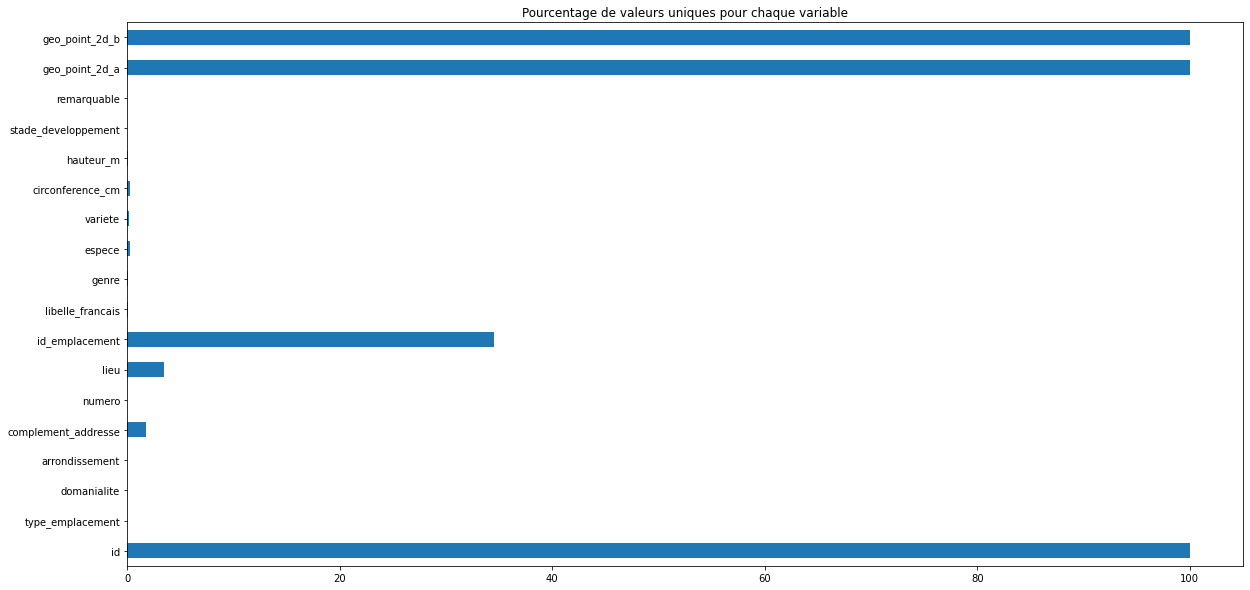

In [24]:
plt.figure(figsize=(20, 10))
s_u_pc.plot.barh()
plt.title("Pourcentage de valeurs uniques pour chaque variable")

<h4>3.2- Feature Engineering</h4>

Parmi les variables numériques, on peut remarquer que :
- la variable "numero" ne contient aucune donnée. Il n'y aura donc aucune perte d'information à la suprimer
- la variable "type_emplacement" ne contient qu'une seul valeur : Arbre. Elle ne donne donc aucune information particulière aux enregistrements pour les différencier. On peut donc supprimer cette variable.
- les statistiques de moyenne, variance etc. n'ont de sens que pour la circonférence et la hauteur des arbres et peut-être pour les données de localisation

Comme on peut le voir, les variables textes qui ont un très faible pourcentage de valeurs uniques, les variables domanialite, arrondissement, lieu, libelle_francais, genre, espece, variete, stade_developpement et remarquable, peuvent être considérées comme des variables qualitatives catégorielles car elles peuvent regrouper derrière elles tout un ensemble d'arbres qui peuvent être traités ensemble. Par exemple "les arbres de genre Fagus des jardins du 16ème arrondissement". 

Suppression des variables "numero" et "type_emplacement:

In [25]:
df2 = dfOriginelMC.drop(["numero", "type_emplacement"], axis=1)

<h4>3.3- Gestion des NaN</h4>

In [26]:
df2.isna().sum()

id                          0
domanialite                 1
arrondissement              0
complement_addresse    169235
lieu                        0
id_emplacement              0
libelle_francais         1497
genre                      16
espece                   1752
variete                163360
circonference_cm            0
hauteur_m                   0
stade_developpement     67205
remarquable             63098
geo_point_2d_a              0
geo_point_2d_b              0
dtype: int64

Mais qu'est-ce qu'une NaN ? 
- Il n'est pas facile de trouver une définition précise. 
- Ce serait "une constante qui indique que la valeur donnée n’est pas légale - Not a Number". 
- Mais qu'est-ce qu'une valeur légale ? 
- Par exemple pour les variables circonference_cm et hauteur_m, il existe des valeurs 0 n'ayant pas de sens pour des mesures d'arbres, elles sont sans doute le résultat d'une valeur numérique par défaut. On peut considérer qu'elles faussent les données globales (par exemple pour des moyennes). Sont-elles donc "illégales" ? Pourtant elles sont bien "a number", donc un not(not a number) donc elles ne seraient pas des NaN. En fait, un NaN est une valeur manquante, elles sont donc comptabilisées même si elles appartiennent à des colonnes de format texte, comme c'est le cas pour la colonne "complement_adresse".
- Concernant la valeur 0 des colonnes circonference_cm et hauteur_m ce n'est pas parce qu'on ne doit pas les considérer comme des NaN qu'il faut quand même prendre le risque de les voir fausser les statistiques. On verra plus loins comment les traiter à part. 
- A première vue, les valeurs manquantes des variables complement_adresse, libelle_francais, genre, espece, variete et stade_developpement ne peuvent pas être remplacées ou extrapolées à partir des autres données.
- La variable "remarquable" possède deux modalités, 0 et 1. Mais pour les données manquantes, pour savoir s'il est possible de les extrapoler à partir des autres données, il faut étudier si chaque arbre remarquable est corrélé à tout ou partie d'autres variables. Par exemple si le critère de remarquabilité était l'appartenance à une espèce particulière, alors on aurait une forte probabilité de remplacer la valeur manquante par 1. Nou verrons cela plus loin. 

Mise à jour de la NaN de la variable domanialite par sa valeur très probable:
- la colonne "domanialite" ne contient qu'une NaN
- or pour cet enregistement, la colonne "lieu" renseigne une des modalités de la variable "domanialite" puisqu'elle indique qu'il s'agir d'un jardin
- on pourrait donc simplement combler la NaN de la domanialite par cette modalité
- toutefois, dans d'autres cas il pourrait être fastidueux de le faire si jamais le nombre de NaN était très élevé. Il est donc préférable d'industrialiser cette méthode en créant une procédure qui irait chercher dans la colonne "lieu" une trace des modalités de "domanialite" afin de combler les trous de la colonne "domanialite" quand cela est possible. 

In [27]:
domna = pd.isna(df2['domanialite'])
domnas = df2.iloc[domna[domna == True].index,:]
print(domnas)
domanialite_modes = list(df2['domanialite'].unique())
del domanialite_modes[-1]
import re
def search_domanialite_modes_in_lieu(row):
    domanialite_mode = ""
    for m in domanialite_modes:
        x = re.findall(m, row['lieu'])
        if len(x) == 1:
            domanialite_mode = m
            break
    print(m)
    index = df2[df2.id == row['id']].index[0]
    print(index)
    df2.iloc[index ,1] = m
    
domnas.apply(search_domanialite_modes_in_lieu, axis = 1)
df2.iloc[197239 ,:]

             id domanialite   arrondissement complement_addresse  \
197239  2020911         NaN  PARIS 20E ARRDT                 NaN   

                                                     lieu id_emplacement  \
197239  JARDINS D IMMEUBLES PORTE DE VINCENNES NORD / ...         203006   

       libelle_francais         genre   espece variete  circonference_cm  \
197239      CHIMONANTHE  CHIMONANTHUS  PRAECOX     NaN                35   

        hauteur_m stade_developpement  remarquable  geo_point_2d_a  \
197239          4                  JA          0.0       48.849547   

        geo_point_2d_b  
197239         2.41419  
JARDIN
197239


id                                                               2020911
domanialite                                                       JARDIN
arrondissement                                           PARIS 20E ARRDT
complement_addresse                                                  NaN
lieu                   JARDINS D IMMEUBLES PORTE DE VINCENNES NORD / ...
id_emplacement                                                    203006
libelle_francais                                             CHIMONANTHE
genre                                                       CHIMONANTHUS
espece                                                           PRAECOX
variete                                                              NaN
circonference_cm                                                      35
hauteur_m                                                              4
stade_developpement                                                   JA
remarquable                                        

Maintenant qu'on a géré les NaN comme on le pouvait, on veut visualiser leur distribution "incompressible":

<AxesSubplot:>

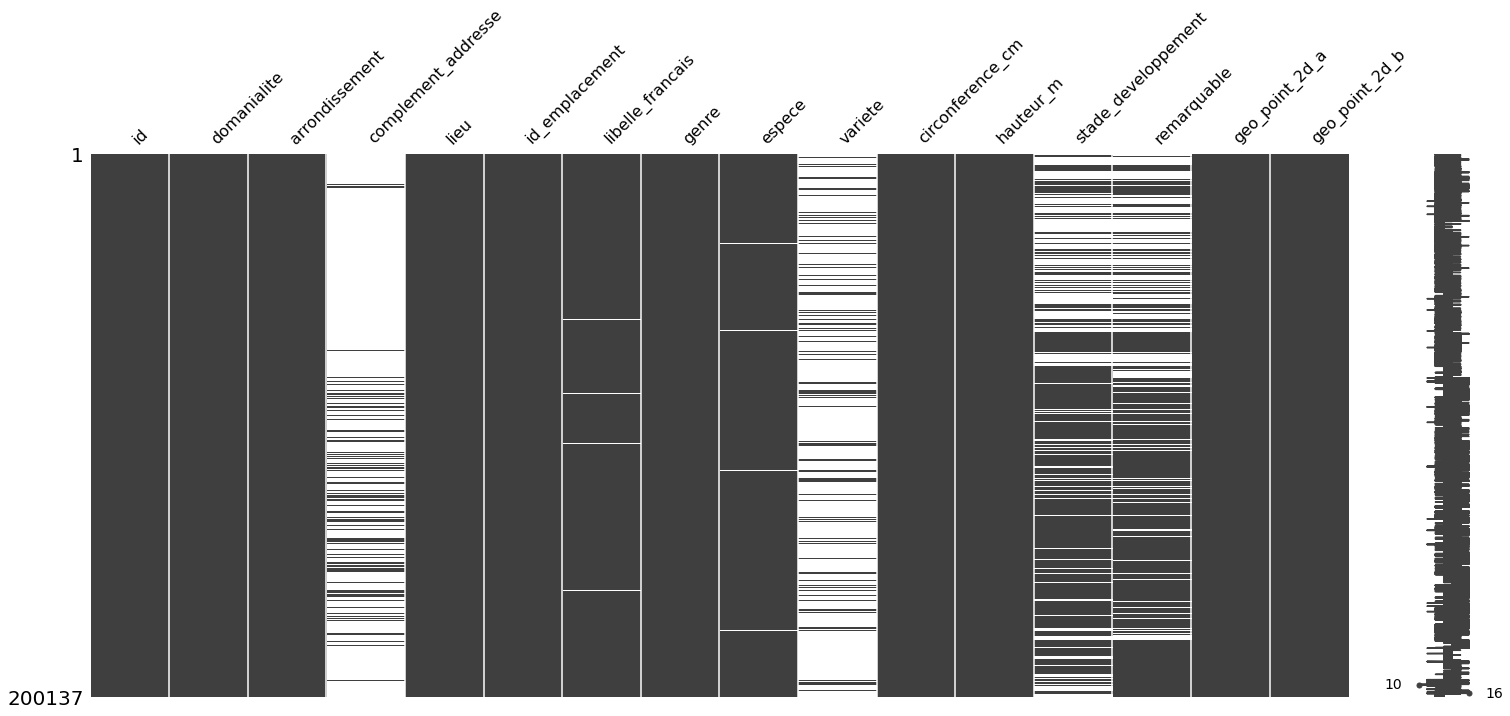

In [61]:
import missingno as msno
msno.matrix(df2)

<h4>3.4- Valeurs potentiellement hors-sujet</h4>
- Je pense que si on doit gérer les valeurs manquantes, il faut aussi s'intéresser aux données "en trop" qui ne semblent pas correspondre à l'objectif du projet. Par exemple, il s'agit d'un projet pour la gestion des arbres de Paris. Or il y a dans ces données des arbres qui appartiennent à des cimetierres en dehors de Paris. Par exemple, que viennent faire les cimetierres de Nanterre, de Pantin ou de Bagneux dans les données de Paris ? Si on devait tenir compte de ces toutes ces villes d'Île de France, dans ce cas il faudrait aussi prendre les domanialités autre que cimetierre pour ces villes. Or elles ne sont pas présentes dans les données. Toutefois, rien n'indique qu'il ne faille pas les prendre en compte, peut-être ces cimetierres sont-ils gérés par la ville de Paris. Je choisis donc de les laisser dans le jeu de données, même si parfois par exemple pour des agrégats sur les arrondissements, je ne me concentrerai que sur Paris où on dispose de toutes les informations par entité administrative.<br>
- On pourra aussi remarquer que certains arbres ne sont pas présents dans les données. Par exemple les arbres des jardins du Luxembourg et du Muséum d'Histoire Naturelle (qui doit pourtant compter des arbres "remarquables"). On notera aussi que la très grande majorité des arbres des bois de Boulogne et de Vincennes ne sont pas présents.<br>
- De la même façon, d'après le site agriculture.gouv.fr, la ville de Paris gère près de 100 000 arbres d'alignement (en effet, les données font état de 99 548 arbres dans la domanialité Alignement), 40 000 dans les parcs, jardins et squares et plus de 300 000 arbres dans les deux bois. Or nous verrons plus loin que seuls les arbres des alignements des bois sont présents. Donc quand on parle des arbres des bois, il faut garder à l'esprit qu'il ne s'agit que des arbres des alignements.

<h4>3.5- Valeurs extrêmes et les valeurs aberrantes</h4>
- Pour montrer les valeurs extrêmes et les valeurs aberrantes, on peut utiliser le boxplot de Seaborn. On poura uiliser le violin de Seaborn pour voir les distributions des variables plutôt relativement par exemple aux espèces d'arbres.

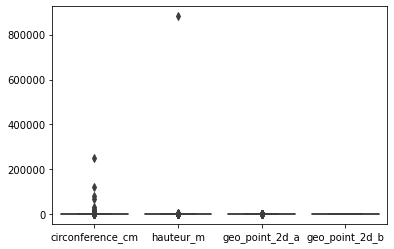

In [29]:
df_num = dfOriginel[["circonference_cm", "hauteur_m", "geo_point_2d_a", "geo_point_2d_b"]]
ax = sns.boxplot(data=df_num, orient="v")

On peut voir que la variable hauteur_m possède une valeur aberrante et si la circonférence_cm montre un boxplot somme toute classique, bon nombre de valeurs sont également aberrantes quand on les compare avec la réalité des arbres, surtout à Paris.

L'arbre le plus haut du monde s'appelle Hyperion et mesure 115.65 de hauteur. Il est donc improbable d'avoir des mesures au-delà de cette hauteur à Paris, surtout pour l'arbre qui ferait 881818 mètres (max de la colonne hauteur_m). On peut donc raisonnablement considérer que les données de la colonne hauteur_m supérieure par exemple à 115 mètres sont des valeurs aberrantes et les supprimer. Toutefois, on sait qu'à Paris, le plus haut arbre est un platane de près de 30 mètres. On peut donc ne pas tenir compte des valeurs supérieures à 31 mètres. Toutefois, avant de supprimer ces valeurs, il faut étudier s'il faut supprimer les enregistrements dans leur ensemble ou juste annuler la valeur de la variable, ou la remplacer par une valeur à choisir. Si les autres valeurs des enregistrements sont utiles et ont un sens, il ne faut pas les supprimer.
Il en va de même pour la variable circonference_cm qu'on limitera à 850 (le plus gros arbre parisien ayant une circonférence d'environ 8 mètres). On peut également ne retenir que les arbres dont la hauteur et la circonférence est supérieure à 0.

In [30]:
df3_non_aberrant = df2[(df2["hauteur_m"] < 31) & (df2["hauteur_m"] > 0) & (df2["circonference_cm"] < 850) & (df2["circonference_cm"] > 0)]

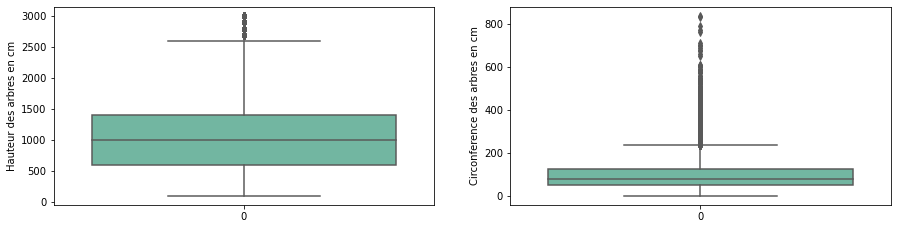

In [31]:
df_num2 = df3_non_aberrant[["circonference_cm", "hauteur_m"]]
df_num2["hauteur_m"] = df_num2["hauteur_m"] * 100
plt.figure(figsize=(15,8))
plt.subplot(221)
plt.ylabel("Hauteur des arbres en cm")
ax = sns.boxplot(data=df_num2.hauteur_m, palette="Set2")
plt.subplot(222)
plt.ylabel("Circonference des arbres en cm")
ax = sns.boxplot(data=df_num2.circonference_cm, palette="Set2")
plt.show()

Homogénéité de la répartition des arbres dans Paris:

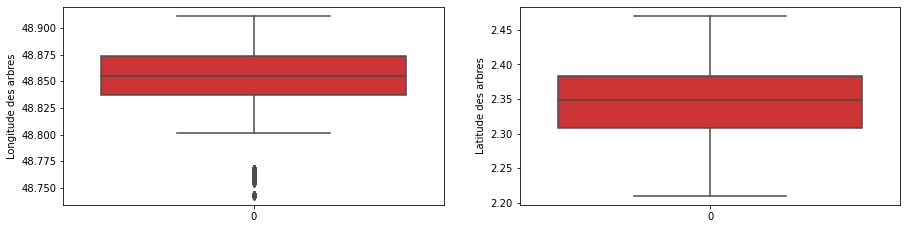

In [32]:
df_num1 = df3_non_aberrant[["geo_point_2d_a", "geo_point_2d_b"]]
plt.figure(figsize=(15,8))
plt.subplot(221)
plt.ylabel("Longitude des arbres")
ax = sns.boxplot(data=df_num1.geo_point_2d_a, palette="Set1")
plt.subplot(222)
plt.ylabel("Latitude des arbres")
ax = sns.boxplot(data=df_num1.geo_point_2d_b, palette="Set1")
plt.show()


En traçant un rectangle des 1er et 3ème quartiles de latitude et longitude du positionnement des arbres, on peut voir que les arbres sont globalement bien répartis sur tout Paris. Il n'y a pas de déséquilibres vers un ou plusieurs des points cardinaux.

In [33]:
r = folium.Map([48.863303, 2.342317], zoom_start=12)
folium.Rectangle([(48.838, 2.31), (48.875, 2.38)], fill=True, weight=3, fill_color="yellow", color="red").add_to(r)
r

<h2>4- Analyse univariée</h2>

Remarque préalable importante: <br>
Afin de pouvoir comparer les arrondissements entre eux, je ne considère que les arrondissements "bétonnés"... <br>
C'est-à-dire que même si le Bois de Boulogne appartient au 16ème arrondissement et le Bois de Vincennes appartient au 12ème arrondissement, pour comparer ce qui est comparable, je n'inclue pas les arbres des alignements des bois puisqu'ils ont été sortis des arrondissements habituels dans les données. Ils restent représentés sur les cartes, mais je ne les prends pas en commpte pour les calculs de nombre et de densité par exemple. 

<h4>4.1- Nombre d'arbres par arrondissement parisien</h4>

In [34]:
df_trees_by_arrd = df3_non_aberrant[df3_non_aberrant.arrondissement.str.contains('^PARIS')]
df_trees_by_arrd_series = df_trees_by_arrd.groupby('arrondissement').size()
df_trees_by_arrd = pd.DataFrame({'number of trees':df_trees_by_arrd_series})
df_trees_by_arrd = df_trees_by_arrd.sort_values(by=['number of trees'], ascending=False)
df_trees_by_arrd

,number of trees
arrondissement,
PARIS 16E ARRDT,14992
PARIS 13E ARRDT,13563
PARIS 20E ARRDT,12898
PARIS 12E ARRDT,12075
PARIS 15E ARRDT,11417
PARIS 14E ARRDT,11328
PARIS 19E ARRDT,10274
PARIS 17E ARRDT,8654
PARIS 7E ARRDT,8427


<h4>4.2- Densité d'arbres par arrondissement parisien</h4>

In [35]:
surfaces = [791, 715, 598, 637, 848, 564, 679, 567, 409, 601, 388, 367, 289, 160, 254, 215, 183, 117, 218, 99]
# (source : https://fr.wikipedia.org/wiki/Arrondissements_de_Paris)
df_trees_by_arrd['surface'] = surfaces
df_trees_by_arrd['ratio'] = df_trees_by_arrd['number of trees'] / df_trees_by_arrd['surface']
df_trees_by_arrd = df_trees_by_arrd.sort_values(by=['ratio'], ascending=False)
df_trees_by_arrd

,number of trees,surface,ratio
arrondissement,,,
PARIS 20E ARRDT,12898,598,21.568562
PARIS 7E ARRDT,8427,409,20.603912
PARIS 14E ARRDT,11328,564,20.085106
PARIS 13E ARRDT,13563,715,18.969231
PARIS 12E ARRDT,12075,637,18.956044
PARIS 16E ARRDT,14992,791,18.953224
PARIS 8E ARRDT,7030,388,18.118557
PARIS 4E ARRDT,2686,160,16.787500
PARIS 17E ARRDT,8654,567,15.262787


Remarque sur les Bois:

In [36]:
df_bois = df3_non_aberrant[df3_non_aberrant.arrondissement.str.contains('^BOIS')]
df_bois.groupby('arrondissement').size()

arrondissement
BOIS DE BOULOGNE     3277
BOIS DE VINCENNES    8082
dtype: int64

Les superficies des deux bois sont respectivement de 846 et de 995 hectares pour les Bois de Boulogne et de Vincennes. <br>(source : https://fr.wikipedia.org/wiki/Arrondissements_de_Paris)<br>
Ce qui fait un ratio de 3.873522 et 8.122613 arbres par hectare, ce qui les placerait dans les surfaces les moins denses en arbres. Toutefois cela n'a pas de sens puisqu'il s'agit pour les bois que d'arbres des alignements et non des arbres des bois eux-mêmes. Il y aurait en effet plus de 300 000 arbres dans les bois. Ceux-ci ne sont pas présents dans les données.

<h4>4.3- Statistiques sur les variables numériques</h4>

Les seules variables numériques qui ont du sens pour appliquer les statistiques de moyenne, variance, min/max etc. sont les variables "circonference_cm", "hauteur_m", "geo_point_2d_a", "geo_point_2d_b" car les autres sont plutôt des variables numériques modales ("id" est, lui, un identifiant incrémenté). Donc faire une moyenne sur des références de catégories n'a pas de sens. On les étudiera d'une autre façon plus loin.

In [37]:
df_num.describe()

,circonference_cm,hauteur_m,geo_point_2d_a,geo_point_2d_b
count,200137.000000,200137.000000,200137.000000,200137.000000
mean,83.380479,13.110509,48.854491,2.348208
std,673.190213,1971.217387,0.030234,0.051220
min,0.000000,0.000000,48.742290,2.210241
25%,30.000000,5.000000,48.835021,2.307530
50%,70.000000,8.000000,48.854162,2.351095
75%,115.000000,12.000000,48.876447,2.386838
max,250255.000000,881818.000000,48.911485,2.469759


Histogramme de la variable hauteur_m

In [38]:
import pandas_bokeh
pandas_bokeh.output_notebook()
pd.set_option('plotting.backend', 'pandas_bokeh')
# Create Bokeh-Table with DataFrame:
from bokeh.models.widgets import DataTable, TableColumn
from bokeh.models import ColumnDataSource

Loading BokehJS ...

In [39]:
df3_non_aberrant[["hauteur_m"]].plot_bokeh(kind="hist",title ="Tree data", figsize =(750,500), xlabel = "Height", ylabel="Trees (units)")

Figure(id='1003', ...)

Histogramme de la variable circonference_cm

In [40]:
df3_non_aberrant[["circonference_cm"]].plot_bokeh(kind="hist",title ="Tree data", figsize =(750,500), xlabel = "Circumference", ylabel="Trees (units)")

Figure(id='1116', ...)

Violin plot de la hauteur des arbres en fonction de l'arrondissement 

Contrairement aux boxplot où tous les éléments sont réellement indiqués, le violin plot utilise une estimation par noyau (kernel density estimation) à partir des données de l'échantillon afin d'estimer la distribution sous-jacente.

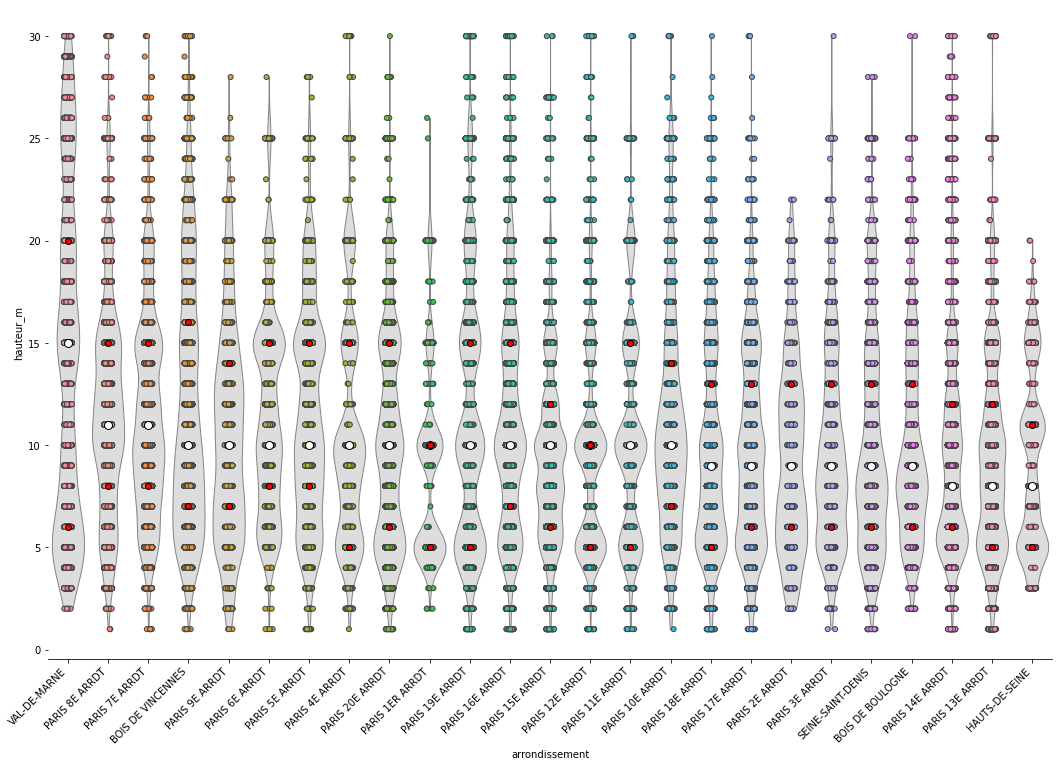

In [41]:
drawDoubleViolin(df3_non_aberrant, 'arrondissement', 'hauteur_m')

Feature engineering, suite : regroupement des domanialités:<br>
En dehors des domanialités Alignement, Cimetière, Jardin et Périphérique, toutes les autres domanialités concernent des administrations de la ville de Paris. On peut éventuellement les regrouper sous la domanialité Administration.<br>

| SIGLE |Description  |
|----- | : ---: |
| DASCO    | Direction des affaires scolaires de la Ville de Paris |
|DAC|Direction des affaires culturelles|
|DFPE|Direction des Familles et de la Petite Enfance|
|DJS|Direction de la Jeunesse et des Sports|
|DASES|Direction de l'Action Sociale de l'Enfance et de la Santé|


In [42]:
df3_non_aberrant['domanialite_gathered'] = df3_non_aberrant['domanialite'].apply(lambda x:'ADMINISTRATION' if x in ['DASCO', 'DAC', 'DFPE', 'DJS', 'DASES'] else x)

On peut vérifier qu'on a bien rassemblé toutes les administrations en une seule catégorie:

In [43]:
df3_non_aberrant['domanialite_gathered'].unique()

array(['JARDIN', 'ALIGNEMENT', 'ADMINISTRATION', 'CIMETIERE',
       'PERIPHERIQUE'], dtype=object)

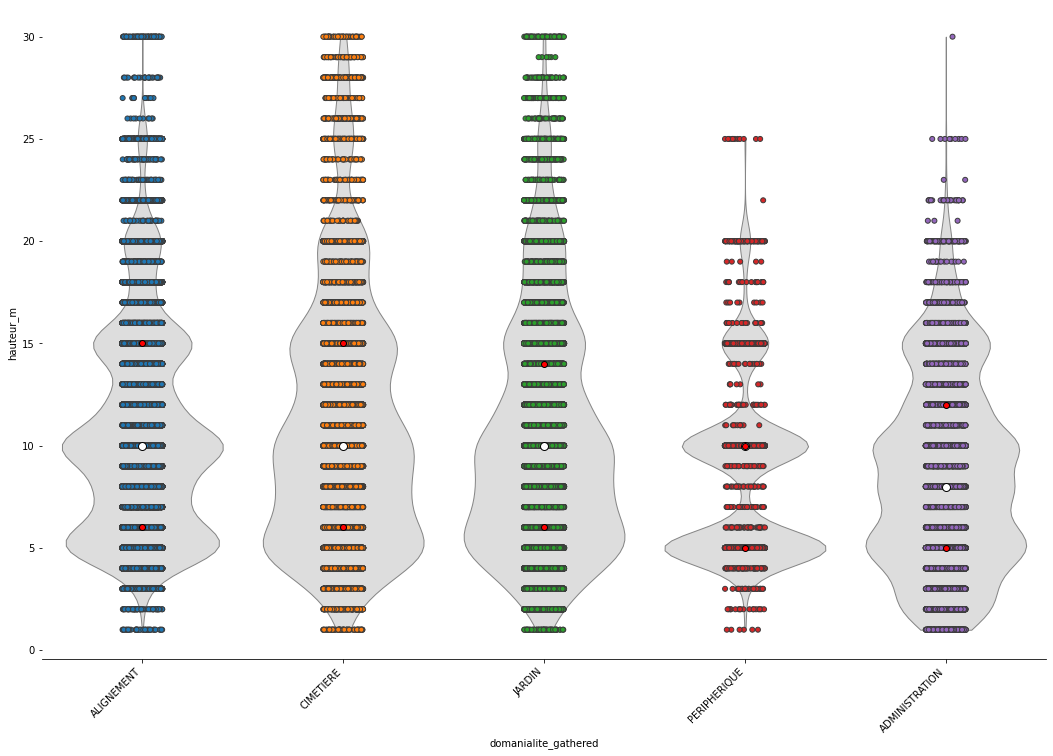

In [44]:
drawDoubleViolin(df3_non_aberrant, 'domanialite_gathered', 'hauteur_m')

<h4>4.4- Statistiques sur les variables catégoriques</h4>

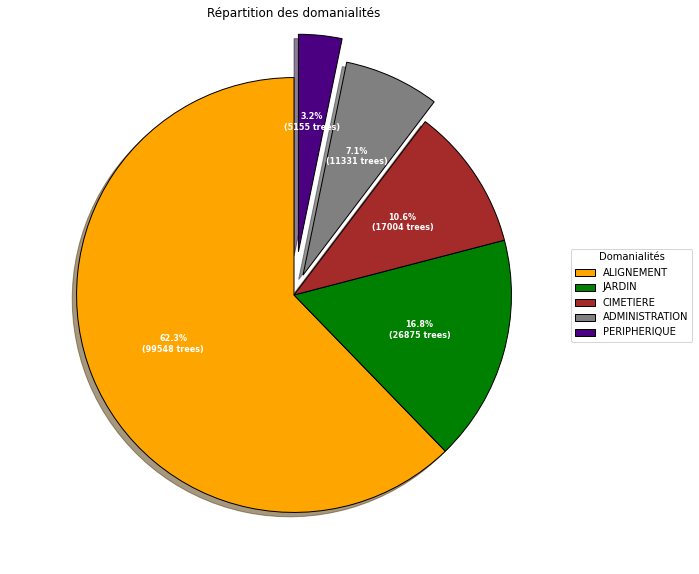

In [45]:
import matplotlib.pyplot as plt
import numpy as np
 
dom_sorted = df3_non_aberrant.groupby(['domanialite_gathered']).size().sort_values(ascending=False)
domanialites = dom_sorted.index
data = dom_sorted.values
 
explode = (0.0, 0.0, 0.0, 0.1, 0.2)
 
colors = ("orange", "green", "brown", "grey", "indigo")
 
wp = {'linewidth': 1, 'edgecolor': "black"}
 
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d} trees)".format(pct, absolute)
 
fig, ax = plt.subplots(figsize=(15, 10))
wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data), explode=explode, labels=domanialites,
                                  shadow=True, colors=colors, startangle=90, wedgeprops=wp,
                                  textprops=dict(color="white"))
 
ax.legend(wedges, domanialites, title="Domanialités", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=8, weight="bold")
ax.set_title("Répartition des domanialités")
 
plt.show()

Il est difficile de faire la même chose pour les autres variables catégorielles que sont les espèces, genres et variétés puisqu'elles ont toutes plus de 175 catégories. Il faudrait trouver un moyen des les regrouper. Mais, dans le cadre d'une analse univariée, cela semble difficile avec le peu d'informations dont on dispose dans ce dataset. Cela pourrait se faire en ajoutant des features extérieures, par exemple les différentes vitesses de pousse des arbres en fonction des variétés, leur durée de vie, leur résistence à la pollution, leur capacité à absorber le CO2, la quantité de feuilles qu'il faut rammasser à l'automne, etc.

<h2>5- Cartographie</h2>

<h4>5.1- Géovisualisation des 5 espèces d'arbres les plus représentés à Paris</h4> 

In [46]:
templateBestNtreesForCol = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 240px;'>
     
<div class='legend-title'>Legend (draggable!)</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:black;opacity:0.7;'></span>Platane</li>
    <li><span style='background:blue;opacity:0.7;'></span>Marronnier</li>
    <li><span style='background:yellow;opacity:0.7;'></span>Tilleul</li>
    <li><span style='background:red;opacity:0.7;'></span>Erable</li>
    <li><span style='background:green;opacity:0.7;'></span>Sophora</li>
  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macroBestNtreesForCol = MacroElement()
macroBestNtreesForCol._template = Template(templateBestNtreesForCol)

In [47]:
def getBestNtreesForCol(_df, _n, _col):
    return _df.groupby([_col]).size().sort_values(ascending=False)[:_n].index

def tree_col(x):
  
  if x=='PLATANE':
    return 'black'
  if x=='MARRONNIER':
    return 'blue'
  if x=='TILLEUL':
    return 'yellow'
  if x=='ERABLE':
    return 'red'
  if x=='SOPHORA':
    return 'green'
  if x=='FRÊNE':
    return 'grey'
  if x=='MICOCOULIER':
    return 'brown'
  if x=='PEUPLIER':
    return 'purple'
  if x=='NOISETIER DE BYZANCE':
    return 'orange'
  if x=='CHÊNE':
    return 'pink'

def drawFoliumHeatMapBestNtreesForCol(_df, _n, _col, _macro):

    df_bestNtrees = _df[_df[_col].isin(getBestNtreesForCol(_df, _n, _col))]
    print("Liste des arbres les plus présents à Paris : ", getBestNtreesForCol(_df, _n, _col))
    
    df_bestNtrees['color_tree'] = df_bestNtrees[_col].apply(lambda x:tree_col(x) )
    
    data = df_bestNtrees.loc[:, ["geo_point_2d_a", "geo_point_2d_b"]].values.tolist()

    m = folium.Map([48.863303, 2.342317], zoom_start=12)

    HeatMap(data).add_to(folium.FeatureGroup(name='Heat Map').add_to(m))
    folium.LayerControl().add_to(m)
    
    df_bestNtrees.apply(lambda x:folium.Circle(location=[x['geo_point_2d_a'], x['geo_point_2d_b']], radius=10, fill=True, color=x['color_tree']).add_to(m), axis=1)
    
    m.get_root().add_child(_macro)
    
    return m

#drawFoliumHeatMapBestNtreesForCol(df3_non_aberrant, 5, 'libelle_francais', macroBestNtreesForCol)

<img src="OCR_IA_P2_répartition_des_5_espèces_d_arbres_les_plus_représentés.JPG" alt="OCR_IA_P2_répartition_des_5_espèces_d_arbres_les_plus_représentés.JPG" style="width: 200px;"/>

<h4>5.2- Géovisualisation des hauteurs des arbres</h4>

In [48]:
templateHauteur = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 240px;'>
     
<div class='legend-title'>Legend (draggable!)</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:green;opacity:0.7;'></span>[0-4] mètres</li>
    <li><span style='background:blue;opacity:0.7;'></span>[5-9] mètres</li>
    <li><span style='background:yellow;opacity:0.7;'></span>[10-14] mètres</li>
    <li><span style='background:purple;opacity:0.7;'></span>[15-19] mètres</li>
    <li><span style='background:white;opacity:0.7;'></span>[20-24] mètres</li>
    <li><span style='background:black;opacity:0.7;'></span>[25-31] mètres</li>
  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macroHauteur = MacroElement()
macroHauteur._template = Template(templateHauteur)

In [49]:
df3_h = df3_non_aberrant
df3_h['range_hauteur'] = pd.cut(df3_h.hauteur_m, [0,5,10,15,20,25,35], include_lowest=True, labels=['0', '1', '2', '3', '4', '5'])
df3_h[['hauteur_m', 'range_hauteur']]

list_colors_hauteur = ['green', 'blue', 'yellow', 'purple', 'white', 'black']
def color_tree_hauteur(x):
    return list_colors_hauteur[int(x)]

def drawFoliumHeatMapHauteur(_df, _macro):
    dfh = _df
    dfh['color_tree_hauteur'] = dfh['range_hauteur'].apply(lambda x:color_tree_hauteur(x))

    data = dfh.loc[:, ["geo_point_2d_a", "geo_point_2d_b"]].values.tolist()

    m = folium.Map([48.863303, 2.342317], zoom_start=12)

    #HeatMap(data).add_to(folium.FeatureGroup(name='Heat Map').add_to(m))
    folium.LayerControl().add_to(m)
    
    dfh.apply(lambda x:folium.Circle(location=[x['geo_point_2d_a'], x['geo_point_2d_b']], radius=10, fill=True, color=x['color_tree_hauteur']).add_to(m), axis=1)
    
    m.get_root().add_child(_macro)
    
    return m

#drawFoliumHeatMapHauteur(df3_h, macroHauteur)

<img src="OCR_IA_P2_hauteurs_des_arbres.JPG" alt="OCR_IA_P2_hauteurs_des_arbres.JPG" style="width: 200px;"/>

<h4>5.3- Géovisualisation des circonférences des arbres</h4>

In [50]:
templateCirconference = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 240px;'>
     
<div class='legend-title'>Legend (draggable!)</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:green;opacity:0.7;'></span>[1-149] centimètres</li>
    <li><span style='background:blue;opacity:0.7;'></span>[150-299] centimètres</li>
    <li><span style='background:yellow;opacity:0.7;'></span>[300-449] centimètres</li>
    <li><span style='background:purple;opacity:0.7;'></span>[450-649] centimètres</li>
    <li><span style='background:black;opacity:0.7;'></span>[650-850] centimètres</li>
  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macroCirconference = MacroElement()
macroCirconference._template = Template(templateCirconference)

In [51]:
df3_c = df3_non_aberrant
df3_c['range_circonference'] = pd.cut(df3_c.circonference_cm, [0,150,300,450,600,850], include_lowest=True, labels=['0', '1', '2', '3', '4'])
df3_h[['circonference_cm', 'range_circonference']]

list_colors_circonference = ['green', 'blue', 'yellow', 'purple', 'black']
def color_tree_circonference(x):
    return list_colors_circonference[int(x)]

def drawFoliumHeatMapCircumference(_df, _macro):
    dfh = _df
    dfh['color_tree_circonference'] = dfh['range_circonference'].apply(lambda x:color_tree_circonference(x))
    
    data = dfh.loc[:, ["geo_point_2d_a", "geo_point_2d_b"]].values.tolist()

    m = folium.Map([48.863303, 2.342317], zoom_start=12)

    #HeatMap(data).add_to(folium.FeatureGroup(name='Heat Map').add_to(m))
    folium.LayerControl().add_to(m)
    
    dfh.apply(lambda x:folium.Circle(location=[x['geo_point_2d_a'], x['geo_point_2d_b']], radius=10, fill=True, color=x['color_tree_circonference'], opacity=0.2).add_to(m), axis=1)
    
    m.get_root().add_child(_macro)
    
    return m

#drawFoliumHeatMapCircumference(df3_c, macroCirconference)

<img src="OCR_IA_P2_circonférences_des_arbres.JPG" alt="OCR_IA_P2_circonférences_des_arbres.JPG" style="width: 200px;"/>

<h4>5.4- Géovisualisation des arbres remarquables de Paris</h4>

In [52]:
def remarquable_tree_col(x):
  
  if x == 1:
    return 'black'

def drawFoliumHeatMapRemarquableTrees(_df):

    df_remarquable_trees = _df[_df['remarquable'].isin([0, 1])]
    
    df_remarquable_trees['color_tree'] = df_remarquable_trees['remarquable'].apply(lambda x:remarquable_tree_col(x) )
    
    data = df_remarquable_trees.loc[:, ["geo_point_2d_a", "geo_point_2d_b"]].values.tolist()

    m = folium.Map([48.863303, 2.342317], zoom_start=12)

    HeatMap(data).add_to(folium.FeatureGroup(name='Heat Map').add_to(m))
    folium.LayerControl().add_to(m)
    
    df_remarquable_trees.apply(lambda x:folium.Circle(location=[x['geo_point_2d_a'], x['geo_point_2d_b']], radius=30, fill=False, color=x['color_tree']).add_to(m), axis=1)
    
    return m

#drawFoliumHeatMapRemarquableTrees(df3_non_aberrant)

<img src="OCR_IA_P2_répartition_des_arbres_remarquables.JPG" alt="OCR_IA_P2_répartition_des_arbres_remarquables.JPG" style="width: 200px;"/>

<h4>5.5- Géovisualisation des stades de développements des arbres</h4>

In [53]:
templateStadeDeveloppement = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 240px;'>
     
<div class='legend-title'>Legend (draggable!)</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:green;opacity:0.7;'></span>A</li>
    <li><span style='background:blue;opacity:0.7;'></span>J</li>
    <li><span style='background:yellow;opacity:0.7;'></span>M</li>
    <li><span style='background:black;opacity:0.7;'></span>JA</li>
  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macroStadeDeveloppement = MacroElement()
macroStadeDeveloppement._template = Template(templateStadeDeveloppement)

In [54]:
def developpement_tree_col(x):
  
  if x == 'A':
    return 'black'
  if x == 'J':
    return 'blue'
  if x == 'M':
    return 'green'
  if x == 'JA':
    return 'yellow'

def drawFoliumHeatMapDeveloppementTrees(_df, _macro):

    df_developpement_trees = _df[_df['stade_developpement'].isin(df3_non_aberrant['stade_developpement'].unique()[1:])]
    
    df_developpement_trees['color_tree'] = df_developpement_trees['stade_developpement'].apply(lambda x:developpement_tree_col(x) )
    
    data = df_developpement_trees.loc[:, ["geo_point_2d_a", "geo_point_2d_b"]].values.tolist()

    m = folium.Map([48.863303, 2.342317], zoom_start=12)

    folium.LayerControl().add_to(m)
    
    df_developpement_trees.apply(lambda x:folium.Circle(location=[x['geo_point_2d_a'], x['geo_point_2d_b']], radius=30, fill=False, color=x['color_tree']).add_to(m), axis=1)
    
    m.get_root().add_child(_macro)
    
    return m

#drawFoliumHeatMapDeveloppementTrees(df3_non_aberrant, macroStadeDeveloppement)

<img src="OCR_IA_P2_répartition_des_arbres_selon_stade_développement.JPG" alt="OCR_IA_P2_répartition_des_arbres_selon_stade_développement.JPG" style="width: 200px;"/>

<h4>5.6- Géovisualisation des 5 espèces d'arbres les plus représentés à Paris avec la librairie Geopandas</h4>

In [60]:
import geopandas as gpd
nbh_geo_df = gpd.read_file('arrondissements.geojson', driver='GeoJSON')
nbh_geo_df = nbh_geo_df[['c_ar', 'geometry']]

from shapely.geometry import Point, shape

locs_geometry = [Point(xy) for xy in zip(df3_non_aberrant.geo_point_2d_a,
                                         df3_non_aberrant.geo_point_2d_b)]
crs = {'init': 'epsg:4326'}
# Coordinate Reference Systems, "epsg:4326" is a common projection of WGS84 Latitude/Longitude
locs_gdf = gpd.GeoDataFrame(df3_non_aberrant, crs=crs, geometry=locs_geometry)

import folium
locs_map = folium.Map(location=[48.856614, 2.3522219], zoom_start=12, tiles='cartodbpositron')

feature_pl = folium.FeatureGroup(name='PLATANE')
feature_ma = folium.FeatureGroup(name='MARRONNIER')
feature_ti = folium.FeatureGroup(name='TILLEUL')
feature_er = folium.FeatureGroup(name='ERABLE')
feature_so = folium.FeatureGroup(name='SOPHORA')

for i, v in locs_gdf.iterrows():
    popup = """
    Lieu : <b>%s</b><br>
    Nom : <b>%s</b><br>
    Hauteur : <b>%s</b><br>
    Circonférence : <b>%d</b><br>
    """ % (v['lieu'], v['libelle_francais'], v['hauteur_m'], v['circonference_cm'])
    if v['libelle_francais'] == 'PLATANE':
        folium.CircleMarker(location=[v['geo_point_2d_a'], v['geo_point_2d_b']],
                            radius=1,
                            tooltip=popup,
                            color='#FFBA00',
                            fill_color='#FFBA00',
                            fill=True).add_to(feature_pl)
    elif v['libelle_francais'] == 'MARRONNIER':
        folium.CircleMarker(location=[v['geo_point_2d_a'], v['geo_point_2d_b']],
                            radius=1,
                            tooltip=popup,
                            color='#087FBF',
                            fill_color='#087FBF',
                            fill=True).add_to(feature_ma)
    elif v['libelle_francais'] == 'TILLEUL':
        folium.CircleMarker(location=[v['geo_point_2d_a'], v['geo_point_2d_b']],
                            radius=1,
                            tooltip=popup,
                            color='#FF0700',
                            fill_color='#FF0700',
                            fill=True).add_to(feature_ti)
    elif v['libelle_francais'] == 'ERABLE':
        folium.CircleMarker(location=[v['geo_point_2d_a'], v['geo_point_2d_b']],
                            radius=1,
                            tooltip=popup,
                            color='#1ab837',
                            fill_color='#1ab837',
                            fill=True).add_to(feature_er)
    elif v['libelle_francais'] == 'SOPHORA':
        folium.CircleMarker(location=[v['geo_point_2d_a'], v['geo_point_2d_b']],
                            radius=1,
                            tooltip=popup,
                            color='#babfbb',
                            fill_color='#babfbb',
                            fill=True).add_to(feature_so)        

feature_pl.add_to(locs_map)
feature_ma.add_to(locs_map)
feature_ti.add_to(locs_map)
feature_er.add_to(locs_map)
feature_so.add_to(locs_map)
folium.LayerControl(collapsed=False).add_to(locs_map)
#locs_map

<img src="OCR_IA_P2_répartition_5_espèces_les_plus_représentés_avec_géopandas.JPG" alt="OCR_IA_P2_répartition_5_espèces_les_plus_représentés_avec_géopandas.JPG" style="width: 200px;"/>

<h4>5.7- Carte de la densité d'arbre par arrondissement en utilisant les cartes folium GeoJson</h4>

In [56]:
from branca.colormap import linear
def getArrdNumber(_arrd : str) -> int:
    PARIS_pos = _arrd.find("PARIS")
    ARRDT_pos = _arrd.find("ARRDT")
    middle = _arrd[PARIS_pos + 6:ARRDT_pos - 1]
    E_pos = middle.find("E")
    arr = int(middle[:E_pos])
    return arr
df_trees_by_arrd2 = df_trees_by_arrd.reset_index()
df_trees_by_arrd2['c_ar'] = df_trees_by_arrd2['arrondissement'].apply(lambda    x : getArrdNumber(x))

nbh_geo_count_df = pd.merge(nbh_geo_df, df_trees_by_arrd2, on='c_ar')
nbh_count_colormap = linear.YlGnBu_09.scale(min(nbh_geo_count_df['ratio']), max(nbh_geo_count_df['ratio']))
nbh_locs_map = folium.Map(location=[48.856614, 2.3522219], zoom_start = 12, tiles='cartodbpositron')

style_function = lambda x: {
    'fillColor': nbh_count_colormap(x['properties']['ratio']),
    'color': 'black',
    'weight': 1.5,
    'fillOpacity': 0.7
}

folium.GeoJson(
    nbh_geo_count_df,
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=['arrondissement', 'number of trees', 'ratio'],
        aliases=['Arrondissement', 'Number of trees', 'Ratio'],
        localize=True
    )
).add_to(nbh_locs_map)

nbh_count_colormap.add_to(nbh_locs_map)
nbh_count_colormap.caption = 'Tree density'
nbh_count_colormap.add_to(nbh_locs_map)
folium.map.CustomPane('labels').add_to(nbh_locs_map)
folium.TileLayer('CartoDBPositronOnlyLabels', pane='labels').add_to(nbh_locs_map)
nbh_locs_map

<h4>5.8- Carte du nombre d'arbre par arrondissement en utilisant les cartes Choropleth</h4>

In [57]:
geo = gpd.GeoSeries(nbh_geo_df.set_index('c_ar')['geometry']).to_json()
m = folium.Map(location = [48.856614, 2.3522219], zoom_start = 12)

choropleth  = folium.Choropleth(
    geo_data = nbh_geo_count_df.to_json(),
    name = 'Choropleth',
    data = nbh_geo_count_df,
    columns = ['c_ar','number of trees'],
    key_on = 'feature.properties.c_ar',
    fill_color = 'YlGnBu',
    fill_opacity = 0.5,
    line_opacity = 1,
    legend_name = 'Number of trees by district',
    smooth_factor=  0
).add_to(m)

folium.LayerControl(collapsed=True).add_to(m)
choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(
       fields=['arrondissement', 'number of trees'],
       aliases=['District' ,'Number of trees'],
       localize=True
    )
)

display(m)

<h2>6- Conclusion</h2>

Objectifs:

- participer virtuellement au challenge Data sponsorisé par la ville de Paris afin d'aider Paris à devenir une smart-city !

- réaliser une analyse exploratoire avec un jeu de données portant sur les arbres de la ville de Paris

Ce qui a été fait:

- data cleaning (gestion des NaN, uniformisation casse, gestion des valeurs aberrantes)

- feature engineering (suppression des features n'apportant pas d'informations utiles, regroupement de modalités pour la feature domanialité)

- analyse univariée et cartographie

Ce qu’on peut en conclure:

- répartition assez homogène des arbres dans Paris dans les différentes directions, il n'y a pas de réels "déserts végétaux ", même si le centre historique plus bétonné est moins dense en arbres que les arrondissements plus récents de la périphérie. On peut quand même penser qu’en moyenne, Paris ne possède pas beaucoup d’arbres par hectares (ex. 5 dans le 8ème arrondissement), ce qui se confirme en comparant les « green view index » du site https://senseable.mit.edu/treepedia/cities/paris

- beaucoup d'arbres de petite taille (moins de 20 mètres) et de petite circonférence (moins de 250 cm), peu de grands et gros arbres

- les quartiles des hauteurs sont assez similaires dans les arrondissements, seul le Val-de-Marne se détache un peu avec des arbres plus grands dans le cimetière

- il n'y a pas trop non plus de différences suivant la domanialité

- presque deux-tiers des arbres de Paris sont répartis dans les alignements des grandes artères, on les repère effectivement sur les cartes (grandes avenues, boulevards, bois)

Améliorations:

- il serait intéressant de voir la répartition des arbres si on ajoutait les arbres des bois de Boulogne et de Vincennes, même si cela changerait complètement les statistiques.

Il est toutefois pas plus mal de ne pas les avoir intégrés dans le dataset pour bien repérer les éventuelles nuances des arbres « de ville ».

On peut quand même se demander pourquoi, puisqu'il existe une domanialité jardin, la grande majorité des arbres des jardins du Luxembourg ou du Muséum d'Histoire Naturelle ne sont pas présents.

- il serait aussi intéressant de rajouter des features extérieures, par exemple les différentes vitesses de pousse des arbres en fonction des espèces, leur durée de vie, leur résistance à la pollution, leur capacité à absorber le CO2, la quantité de feuilles qu'il faut ramasser à l'automne dont la municipalité doit tenir compte, etc.